In [442]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")    # because pcolormesh doesn't like being given cell centres instead of vertices

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)      # modify bounds to focus on region of interest

hfrz = gpd.read_file("sf_hfrz")

hfrz_px = {'ES':  (7400000, 2350000),
           'GSL': (4880000, 2990000),
           'SC': (4100000, 2100000),
           'LW': (5800000, 1990000),
           'ET': (7000000, 1250000),
           'LA':  (5300000, 2500000),
           'EJB':  (7350000, 1650000),
           'IC':  (4280000, 2900000),
           'WO':  (6200000, 1670000),
           'WS':  (5700000, 2780000),
           'GBL':  (4650000, 3450000),
           'WJB':  (6600000, 1700000),
           'SY':  (4000000, 3600000),
           'NAT':  (7900000, 2180000),
           'SP':  (4820000, 2390000),
           'P':  (4100000, 3200000)}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method to reproject lat/lon onto Lambert coordinates
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# additional methods used to check distributional assumptions
from scipy.stats import kurtosis, skew, kstest, spearmanr

---
# **Exploratory**

- make a map of danger thresholds per province & look at ndays exceeding each level
- MODIS/VIIRS active fires

## **Elevation**

In [54]:
elev = wrap_lon(xr.open_dataset("~/Data/elev.0.25-deg.nc").squeeze(drop = True).data).sel(lon = slice(-140.75, -52.75), lat = slice(43.5, 69.5))
elev = elev.assign_coords({k : (["lat", "lon"], v) for k,v in zip(["x","y"], latlon_to_lambert(elev.rename(lon = "longitude", lat = "latitude")))})

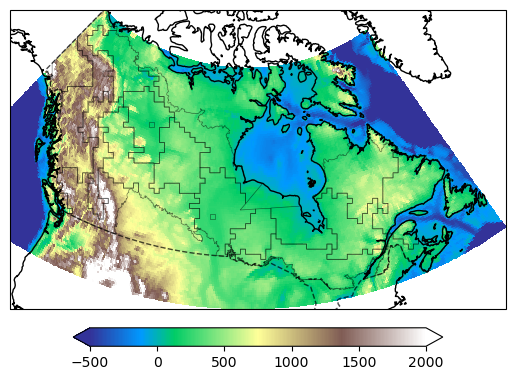

In [68]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
cbar = ax.pcolormesh(elev.x, elev.y, elev, cmap = "terrain", vmin = -500, vmax = 2000)

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, extend = "both")

## **HFRZs & provinces**

### **Map of HFRZs**

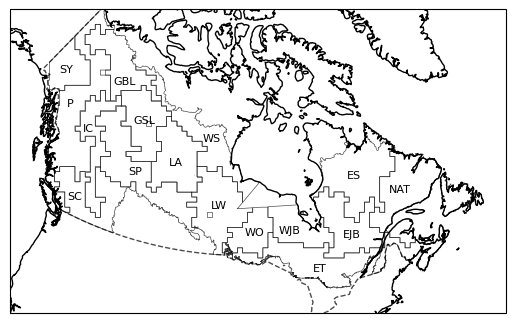

In [570]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

provinces.boundary.plot(ax = ax, color = "w", alpha = 0.5, lw = 0.5, zorder = -999) # force map to same size

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

[ax.annotate(k, xy = v, fontsize = 8) for k, v in hfrz_px.items()]
plt.savefig("fig/maps_hfrz.png")

### **Map of provinces**

In [564]:
provinces = gpd.read_file("sf_provinces").to_crs(cproj).set_index("PRENAME")

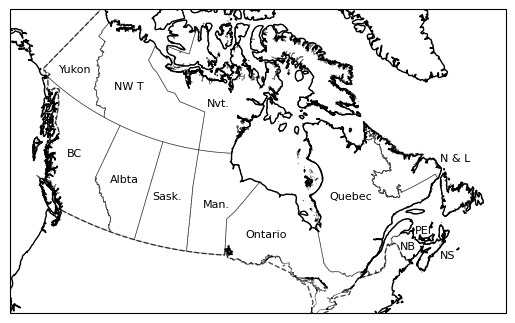

In [566]:
# province_px = {r[1].PREABBR : [r[1].geometry.representative_point().x, r[1].geometry.representative_point().y] for r in provinces.iterrows()}
province_px = {'N & L': [8500000, 2550000],
               'PEI.': [8200000, 1700000],
               'NS': [8500000, 1400000],
               'NB': [8030000, 1500000],
               'Quebec': [7200000, 2100000],
               'Ontario': [6200000, 1650000],
               'Man.': [5700000, 2000000],
               'Sask.': [5100000, 2100000],
               'Albta': [4600000, 2300000],
               'BC': [4100000, 2600000],
               'Yukon': [4000000, 3600000],
               'NW T': [4650000, 3400000],
               'Nvt.': [5750000, 3200000]}

fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

provinces.boundary.plot(ax = ax, color = "k", alpha = 0.5, lw = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

[ax.annotate(k, xy = v, fontsize = 8) for k, v in province_px.items()]
ax.coastlines()

plt.savefig("fig/maps_provinces.png")

### **Provinces with fire danger thresholds & HFRZ boundaries**

In [567]:
provinces = gpd.read_file("sf_provinces").to_crs(cproj).set_index("PRENAME")
fwi_extreme = {"fwi_extreme" : {'Newfoundland and Labrador' : 20,
               'Prince Edward Island' : 21,
               'Nova Scotia' : 23,
               'New Brunswick' : 23, 
               'Quebec' : 20,
               'Ontario' : 22,
               'Manitoba' : 33, 
               'Saskatchewan' : 30,
               'Alberta' : 29, 
               'British Columbia' : 35, # temporary value until I can get a shapefile for the smaller regions
               'Yukon' : 28, 
               'Northwest Territories' : 23,
               'Nunavut' : 23}}
provinces = pd.merge(provinces, pd.DataFrame.from_dict(fwi_extreme), left_index = True, right_index = True)

provinces[["geometry", "fwi_extreme"]].to_file("sf_firerisk")

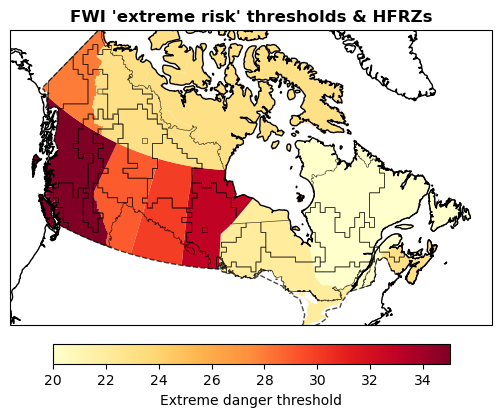

In [582]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

provinces.plot(ax = ax, column = "fwi_extreme", cmap = "YlOrRd", legend = True,
               legend_kwds={"label": "Extreme danger threshold", "orientation": "horizontal", "pad" : 0.05, "shrink" : 0.8})
plt.title("FWI 'extreme risk' thresholds & HFRZs", fontweight = "bold")

plt.savefig("fig/maps_fwi-risk-thresholds.png")

---
---
# **FWI exploratory (ERA5)**

## **Map of cumulative DSR**

In [469]:
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx
fwi = fwi.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(fwi.isel(time = 0, region = 0)))})

dsr = (fwi ** 1.77) * 0.0272
cumdsr = dsr.sum(["region", "time"]).where(dsr.sum(["region", "time"]) > 0)

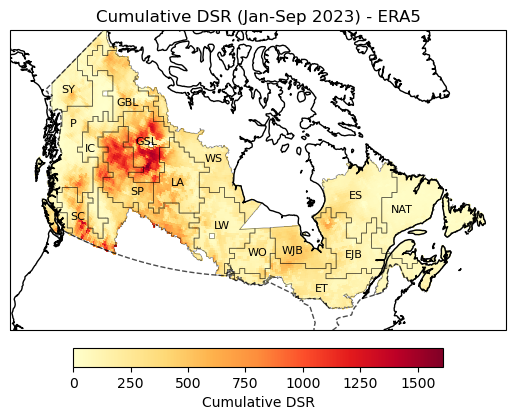

In [470]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
cbar = ax.pcolormesh(cumdsr.x, cumdsr.y, cumdsr, cmap = "YlOrRd", vmin = 0)
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, label = "Cumulative DSR")
plt.title("Cumulative DSR (Jan-Sep 2023) - ERA5")

[ax.annotate(k, xy = v, fontsize = 8) for k, v in hfrz_px.items()]

plt.savefig("fig/expl_era5_cumDSR-2023.png")

### **Number of fire danger days**

In [17]:
sf_fr = gpd.read_file("sf_firerisk").dissolve(by = "fwi_extrem").to_crs("epsg:4326")
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx

# create a regionmask of the FWI threshold for extreme fire risk
rm_fr = regionmask.mask_geopandas(sf_fr, fwi.longitude, fwi.latitude)
rm_fr = rm_fr.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(rm_fr))})

# identify days of extreme fire risk (& mask out regions without fwi data)
fr = xr.ones_like(fwi).where(fwi >= rm_fr, 0).sum(["time", "region"])
fr = fr.where(fwi.sum(["time", "region"]) > 0)

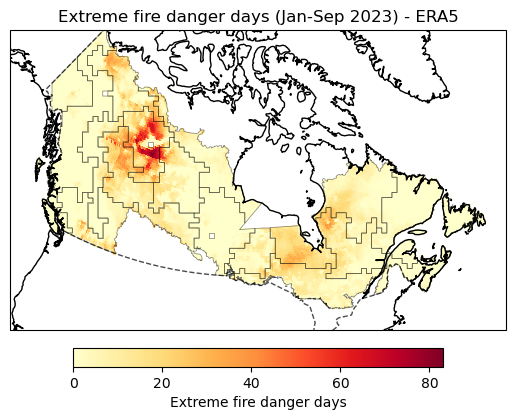

In [36]:
# number of days of extreme fire risk
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

cbar = ax.pcolormesh(fr.x, fr.y, fr, cmap = "YlOrRd", vmin = 0)
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, label = "Extreme fire danger days")

plt.title("Extreme fire danger days (Jan-Sep 2023) - ERA5")

plt.savefig("fig/expl_era5_fire-danger-days-2023.png")

## **Linear trend in log10(cumDSR)**

In [2]:
# cdsr = []
# for fnm in glob.glob("data/era5_fwi_hfrz-*.nc"):
#     fwi = xr.open_dataset(fnm).fwinx
#     last_day = fwi.time.max().dt.dayofyear
    
#     dsr = (fwi ** 1.77) * 0.0272
#     dsr = dsr.sel(time = [d <= last_day for d in dsr.time.dt.dayofyear])      # currently only includes data up to the end of September
#     cdsr.append(dsr.resample(time = "AS-JAN").sum().where(dsr.sum("time") > 0).rename("cdsr"))

# cdsr = xr.concat(cdsr, "region").sortby("region")
# cdsr = cdsr.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(cdsr.isel(time = 0, region = 0)))})
# cdsr = cdsr.assign_attrs(note2 = "DSR accumulated by day "+str(last_day)+" in each year")

# cdsr.to_netcdf("data/era5_cumdsr_gridded.nc")

### **Fitted linear model**

In [271]:
# load cumDSR data, take logs & reset missing areas to NaN
log10_cdsr = np.log10(xr.open_dataset("data/era5_cumdsr_gridded.nc").cdsr.sum("region"))
log10_cdsr = log10_cdsr.where(log10_cdsr.sum("time") != 0)

# replace time with GMST for linear fitting
gmst = pd.read_csv("/home/clair/Data/gmst.dat", comment = "#", sep = " +", header = None, names = ["year", "gmst"], index_col = 0).to_xarray().sel(year = log10_cdsr.time.dt.year).gmst
log10_cdsr = log10_cdsr.assign_coords(time = gmst).rename(time = "gmst")

# fit a linear trend & get residuals
lfit = log10_cdsr.polyfit("gmst", deg = 1).polyfit_coefficients
lfitted = xr.polyval(log10_cdsr.gmst, lfit)
lres = log10_cdsr - lfitted

# relabel main axis as time, rather than GMST
lres = lres.assign_coords(gmst = lres.year).rename(gmst = "time")
log10_cdsr = log10_cdsr.assign_coords(gmst = log10_cdsr.year).rename(gmst = "time")

# estimate return period
rp = 1/norm.sf(log10_cdsr.sel(time = 2023), loc = lfitted.isel(gmst = -1), scale = lres.std("time"))

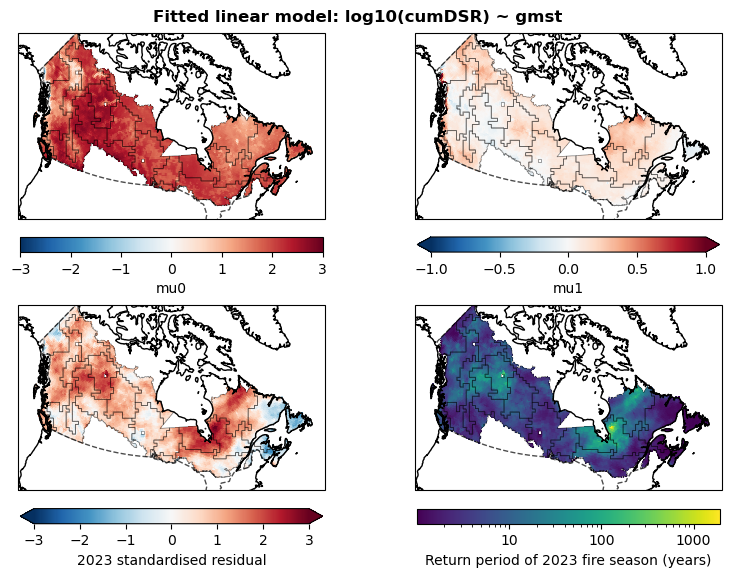

In [473]:
# fitted model at each grid cell
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 6), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05, hspace = 0.2, top = 0.94)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.8, "pad" : 0.08}
axs = fig.axes

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = ax.pcolormesh(lres.x, lres.y, lfit.sel(degree = 0), vmin = -3, vmax = 3, cmap = "RdBu_r")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "mu0")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
cbar = ax.pcolormesh(lres.x, lres.y, lfit.sel(degree = 1), vmin = -1, vmax = 1, cmap = "RdBu_r")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "mu1", extend = "both")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
cbar = ax.pcolormesh(lres.x, lres.y, lres.sel(time = 2023) / lres.std("time"), vmin = -3, vmax = 3, cmap = "RdBu_r")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "2023 standardised residual", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[3]
cbar = plt.pcolormesh(lres.x, lres.y, rp, cmap = "viridis", norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(cbar, ax = plt.gca(), **cbar_kwargs, label = "Return period of 2023 fire season (years)")
cbar.ax.set_xticklabels([0.1,1,10,100,1000,10000,100000])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in fig.axes[:4]:
    ax.coastlines()
    hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.suptitle("Fitted linear model: log10(cumDSR) ~ gmst", fontweight = "bold")

plt.savefig("fig/mdl_era5_cdsr-fitted-model-gridded.jpg")

### **Check normality of log10(cumDSR)**

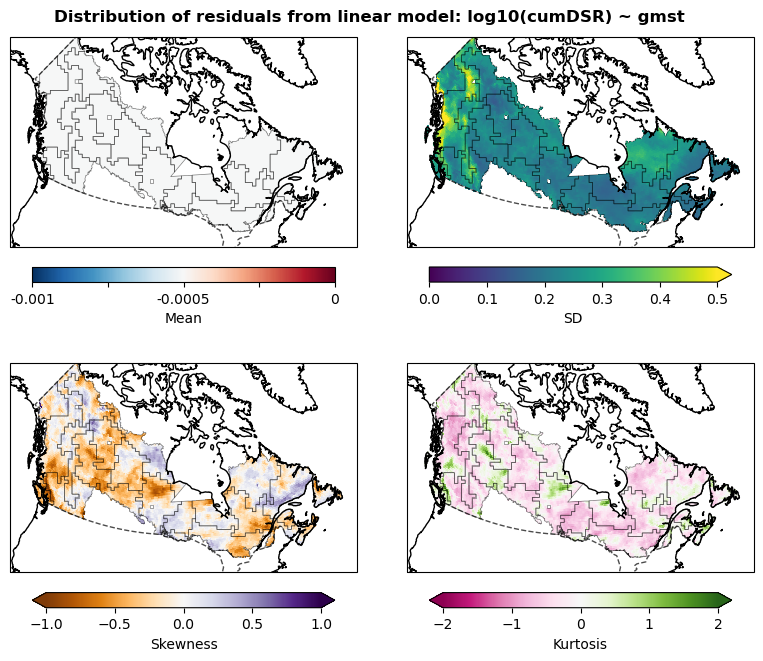

In [298]:
# check distribution of residuals
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 7), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05, hspace = 0.275, top = 0.94)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.8, "pad" : 0.08}
axs = fig.axes

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = ax.pcolormesh(lres.x, lres.y, lres.mean("time"), cmap = "RdBu_r", vmin = -0.001, vmax = 0.001)
cbar = plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Mean")
cbar.ax.set_xticklabels([-.001,"",-0.0005,"",0,"",0.0005,"",0.001])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
cbar = ax.pcolormesh(lres.x, lres.y, lres.std("time"), vmin = 0, vmax = 0.5)
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "SD", extend = "max")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
cbar = ax.pcolormesh(lres.x, lres.y, skew(lres, axis = 0), vmin = -1, vmax = 1, cmap = "PuOr")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Skewness", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[3]
cbar = ax.pcolormesh(lres.x, lres.y, kurtosis(lres, axis = 0), vmin = -2, vmax = 2, cmap = "PiYG")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Kurtosis", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.coastlines()
    hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.suptitle("Distribution of residuals from linear model: log10(cumDSR) ~ gmst", fontweight = "bold")
plt.savefig("fig/mdl_era5_cdsr-linear-res-gridded.jpg")

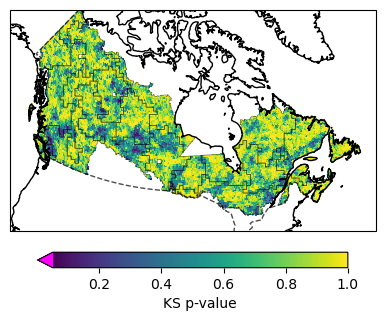

In [472]:
# see if standardised residuals could plausibly be from a standard normal distribution
ks_res = xr.apply_ufunc(lambda x : list(kstest(x, cdf = norm.cdf))[1], lres / lres.std("time"), vectorize = True, input_core_dims = [["time"]])

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
ks_cmap = matplotlib.cm.viridis; ks_cmap.set_under('magenta')

ax = axs
cbar = ax.pcolormesh(lres.x, lres.y, ks_res, vmin = 0.05, vmax = 1, cmap = ks_cmap)
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "KS p-value", extend = "min")

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.savefig("fig/mdl_era5_cdsr-ks-test-gridded.jpg")

In [372]:
xr.ones_like(ks_res).where(ks_res <= 0.05).sum() # one single pixel where we reject the null hypothesis that the distributions are identical

## **cumDSR per HFRZ**

In [376]:
hfrz_dsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).mean(["latitude", "longitude"]) for fnm in sorted(glob.glob("data/era5_fwi_hfrz-*.nc"))]
hfrz_dsr = xr.concat(hfrz_dsr, "region").rename("dsr")
hfrz_dsr.to_netcdf("data/era5_dsr_hfrz-ts.nc")

### **cumDSR relative to previous years**

In [37]:
hfrz_dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

In [165]:
hfrz_cdsr = xr.concat([hfrz_dsr.sel(time = str(y)).cumsum("time") for y in range(1950,2023)], "time")

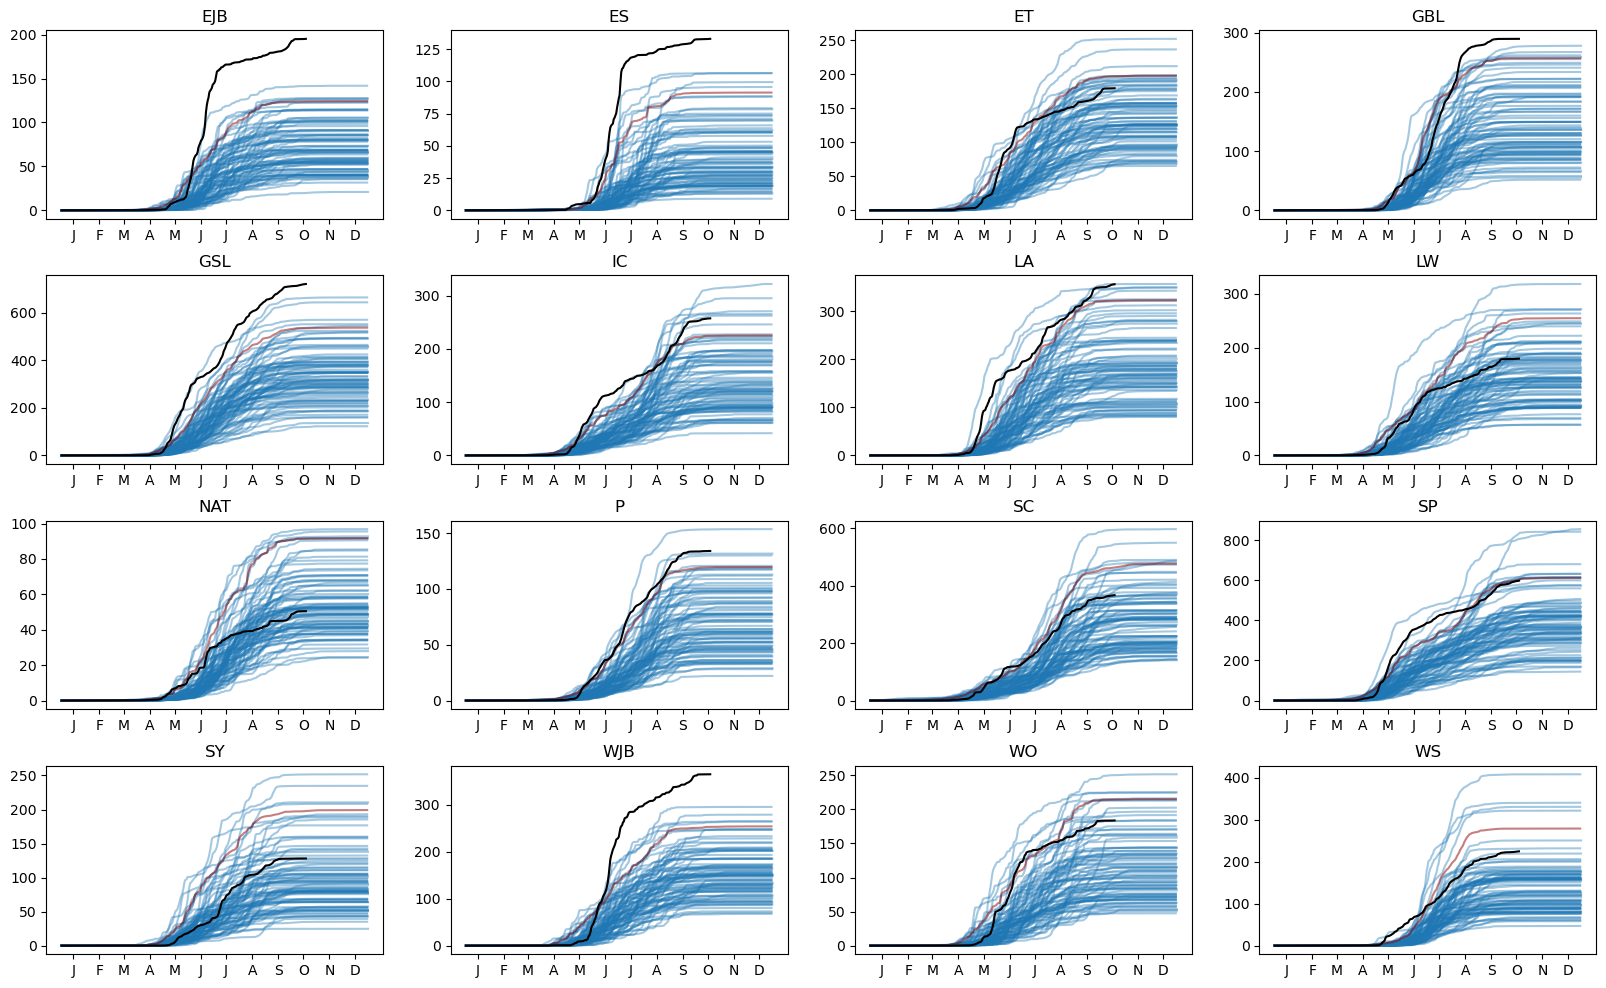

In [175]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_ts = hfrz_dsr.isel(region = i)
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.4)
    
    # 95th percentile of cumsum
    ax.plot(dsr_ts.sel(time = "2022").time.dt.dayofyear, hfrz_cdsr.isel(region = i).groupby("time.dayofyear").quantile(0.95)[:-1], color = "darkred", alpha = 0.5, label = "95th percentile")
    
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "k", alpha = 1, label = "2023")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)

    ax.set_title(dsr_ts.region_name.values)
    
plt.savefig("fig/expl_era5_cumDSR-per-hfrz.png")

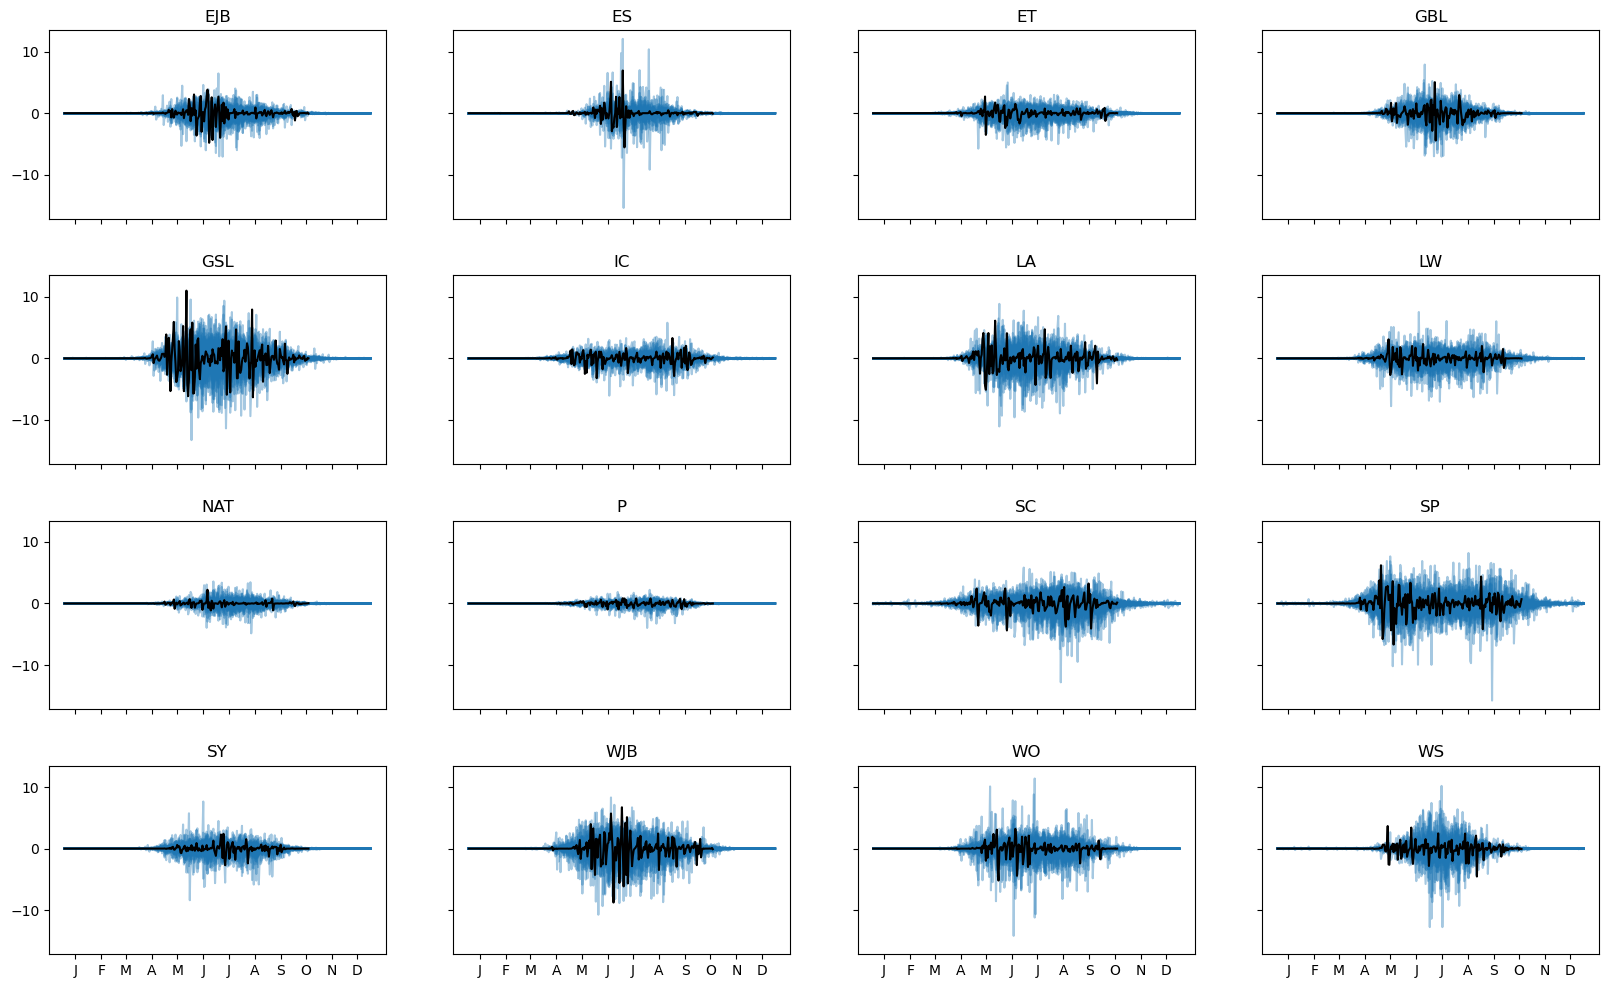

In [176]:
# when did the greatest increases occur?
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_ts = hfrz_dsr.isel(region = i)
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ax.plot(dsr_y.time.dt.dayofyear[1:], dsr_y.diff("time"), color = "tab:blue", alpha = 0.4)
        
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear[1:], dsr_y.diff("time"), color = "k", alpha = 1, label = "2023")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)

    ax.set_title(dsr_ts.region_name.values)
    
plt.savefig("fig/expl_era5_cumDSR-diff-per-hfrz.png")

### **time series of annual cumDSR (to end of September)**

In [379]:
hfrz_dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr

# total DSR over each year (currently only up to end of September due to partial 2023 data)
cdsr = hfrz_dsr.sel(time = [m <= 9 for m in hfrz_dsr.time.dt.month]).resample(time = "AS-JAN").sum()

cdsr.assign_coords(region = cdsr.region_name, time = cdsr.time.dt.year).rename(time = "year").reset_coords(drop = True).to_pandas().transpose().to_csv("data/era5_cdsr.csv")

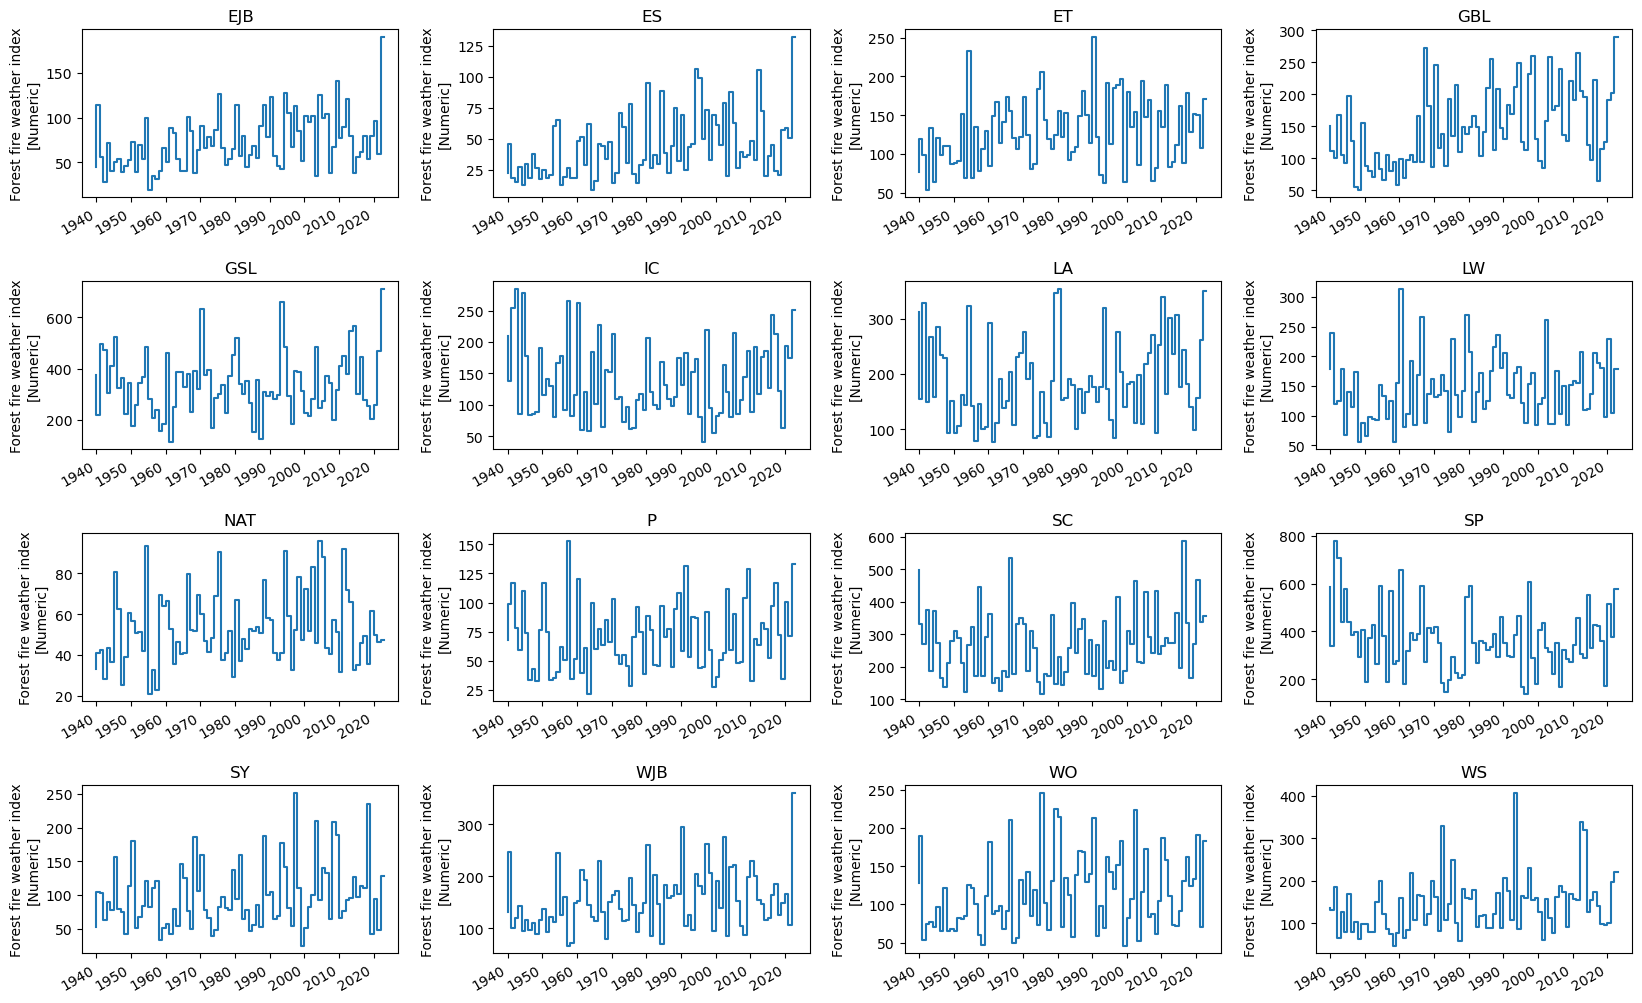

In [36]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    cdsr_ts = cdsr.isel(region = i)
    cdsr_ts.plot(ax = ax, drawstyle = "steps")

    ax.set_title(cdsr_ts.region_name.values)
    ax.set_xlabel("")

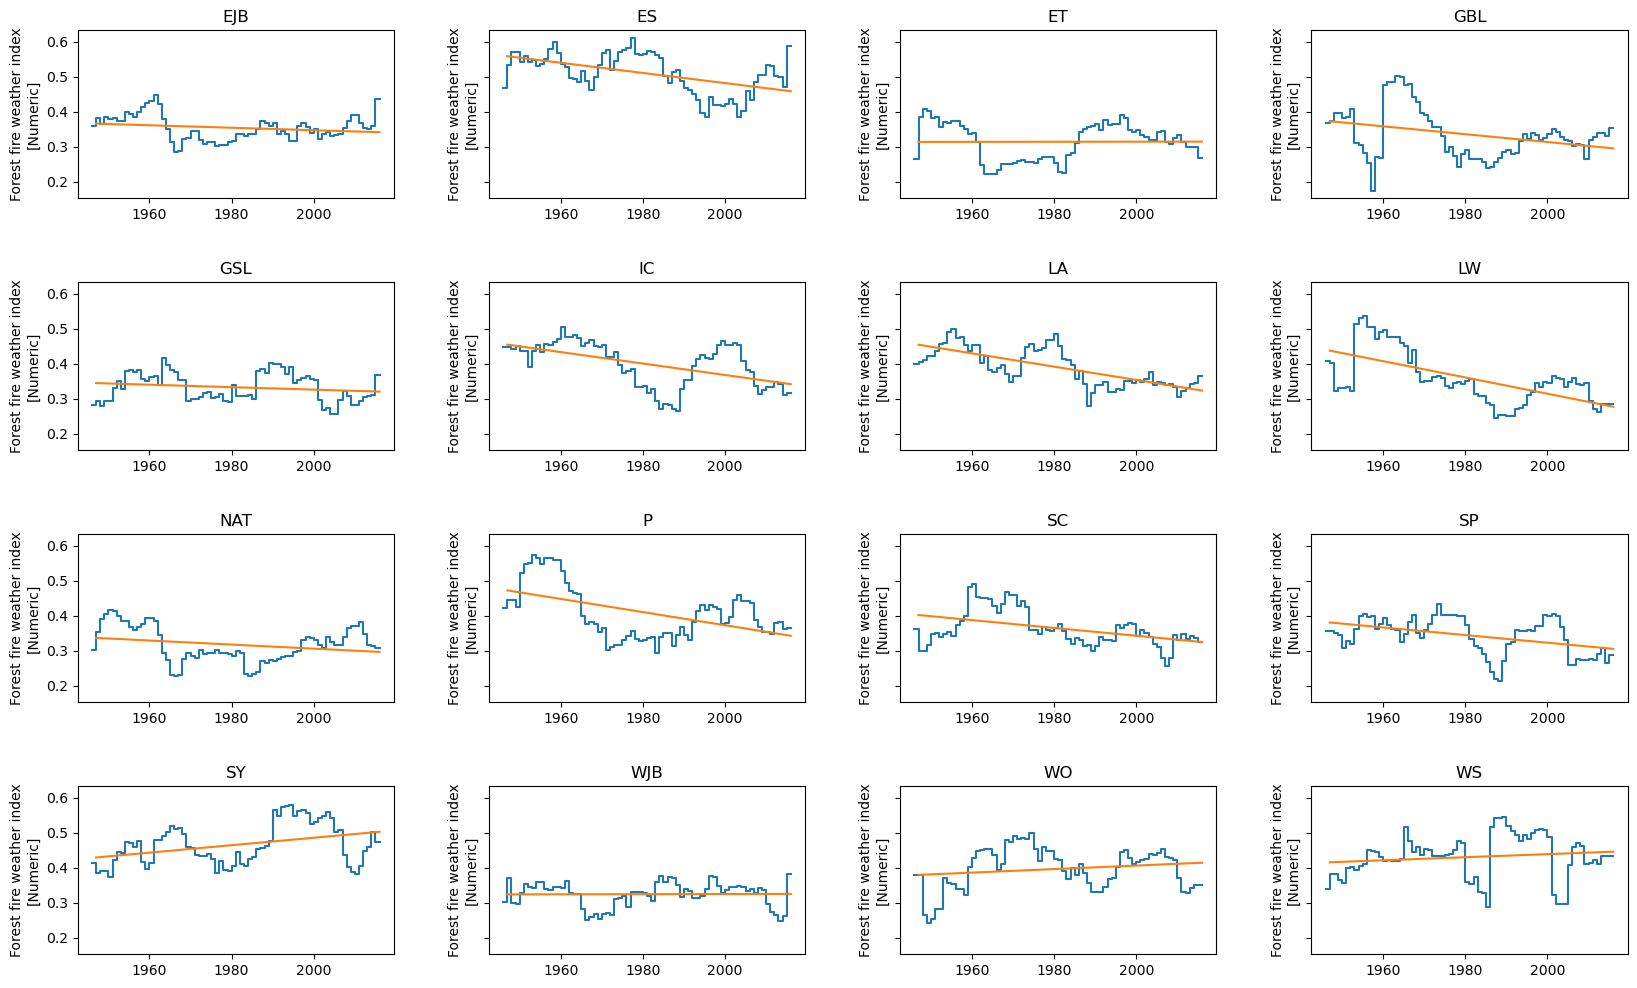

In [415]:
# check running dispersion
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    cdsr_ts = cdsr.isel(region = i).assign_coords(time = cdsr.time.dt.year)
    cdsr_ts = cdsr_ts.rolling(time = 15, center = True).std() / cdsr_ts.rolling(time = 15, center = True).mean()
    cdsr_ts.plot(ax = ax, drawstyle = "steps")
    
    xyline(cdsr_ts.time.values[7:-7], cdsr_ts.values[7:-7], ax = ax)

    ax.set_title(cdsr_ts.region_name.values)
    ax.set_xlabel("")

In [401]:
xyline(cdsr_ts.time.dt.year.values, cdsr_ts.values, ax = ax)

## **cumDSR for whole of Canada**

In [2]:
# get total DSR in each region
cdsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).sum(["latitude", "longitude"]) for fnm in sorted(glob.glob("data/era5_fwi_hfrz-*.nc"))]

# then total DSR over all of Canada
cdsr = xr.concat(cdsr, "region").sum("region")

In [22]:
can_cdsr = xr.concat([cdsr.sel(time = str(y)).cumsum("time") for y in range(1950,2023)], "time")

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

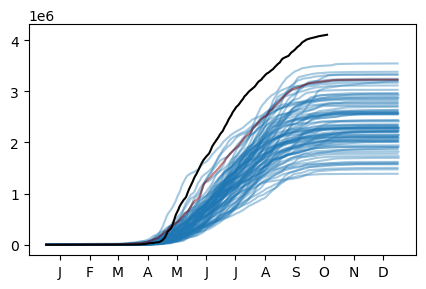

In [24]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5,3), dpi = 100)

for y in range(1941,2022):
    dsr_y = cdsr.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.4)

# 95th percentile of cumsum
ax.plot(cdsr.sel(time = "2022").time.dt.dayofyear, can_cdsr.groupby("time.dayofyear").quantile(0.95)[:-1], color = "darkred", alpha = 0.5, label = "95th percentile")

y = 2023
dsr_y = cdsr.sel(time = str(y))
ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "k", alpha = 1, label = "2023")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

plt.savefig("fig/expl_era5_cumDSR-canada.png")

In [5]:
last_day = cdsr.time.max().dt.dayofyear
can_cdsr = cdsr.sel(time = [d <= last_day for d in cdsr.time.dt.dayofyear])      # currently only includes data up to the end of September

In [8]:
can_cdsr = can_cdsr.resample(time = "AS-JAN").sum().where(can_cdsr.sum("time") > 0).rename("cdsr")

In [17]:
can_cdsr.assign_coords(time = can_cdsr.time.dt.year).rename(time = "year").to_dataframe().to_csv("data/era5_cdsr-canada.csv")

In [18]:

zz = xr.open_dataset("data/era5_cumdsr_gridded.nc")
regionmask.defined_regions.natural_earth_v5_0_0.land_110

<regionmask.Regions>
Name:     Natural Earth: landmask 110m
Source:   http://www.naturalearthdata.com
overlap:  False

Regions:
0 lnd land

[1 regions]

# **MODIS active fire data**


## **Add regions to active fire data**

In [21]:
# load all fire data
modis = pd.concat([pd.read_csv(fnm) for fnm in glob.glob("data/fire_*_M-C61_*.csv")])

# convert to geodataframe (standard lat-lon coords) & reproject geometry
modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")
modis = modis.to_crs(cproj)

# add year & month as columns for easier filtering
modis["y"] = [int(d[:4]) for d in modis.acq_date]
modis["m"] = [int(d[5:7]) for d in modis.acq_date]

# assign each point to a fire region - takes ages so only doing this once! 
zz = gpd.overlay(modis, hfrz.to_crs(epsg = 4326), how='intersection')

# save as .csv (can restore geometry later) - also filter out partial year in 2000
zz.loc[zz.y > 2000].iloc[:,:-1].to_csv("data/modis-active-fires-with-hfrz.csv", index = False)

## **Maps of occurrences**

In [2]:
modis = pd.read_csv("data/modis-active-fires-with-hfrz.csv", parse_dates = ["acq_date"], index_col = "acq_date")
modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")
modis = modis.to_crs(cproj)

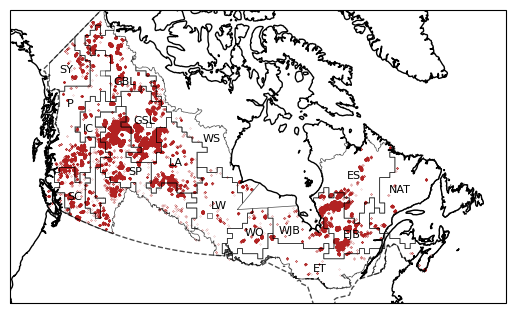

In [189]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

modis.loc[modis.y == 2023].plot(ax = ax, marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
[ax.annotate(k, xy = v, fontsize = 8) for k, v in hfrz_px.items()]

ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
plt.savefig("fig/expl_modis-active-fires-2023.png")

## **Correlation between annual DSR and MODIS active fires**

In [272]:
ycounts = modis.groupby("NAMES_SHOR").resample("AS-JAN").count()[["y"]]
dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr.resample(time = "AS-JAN").sum()
ydsr = dsr.assign_coords(region = dsr.region_name).rename(region = "NAMES_SHOR", time = "acq_date").reset_coords(drop = True).to_dataframe()

df = pd.merge(ycounts.reset_index(), ydsr.reset_index(), on = ["NAMES_SHOR", "acq_date"]).set_index(["NAMES_SHOR"])
ycorr = pd.DataFrame.from_dict({"ycorr" : {r : np.corrcoef(df.loc[(r), "y"], df.loc[(r), "dsr"])[0,1] for r in dsr.region_name.values}})

## **Correlation between MDSR and MODIS active fires**

In [273]:
mcounts = modis.groupby("NAMES_SHOR").resample("MS").count()[["y"]]

In [274]:
dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr.resample(time = "MS").sum()
mdsr = dsr.assign_coords(region = dsr.region_name).rename(region = "NAMES_SHOR", time = "acq_date").reset_coords(drop = True).to_dataframe()

In [443]:
# df = pd.merge(mcounts, cdsr, left_index = True, right_index = True)
df = pd.merge(mcounts.reset_index(), mdsr.reset_index(), on = ["NAMES_SHOR", "acq_date"])
df["m"] = [d.month for d in df.acq_date]
df = df.set_index(["NAMES_SHOR", "m"])
df["y"] = df["y"] + 1  # dummy pixel to avoid infinite values when taking logs etc

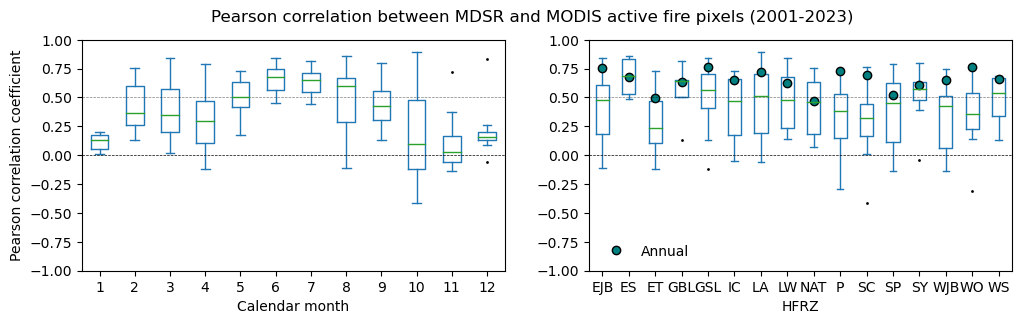

In [444]:
# plot Pearson correlations in each month over all HFRZs
pcorr = pd.DataFrame({r : {m+1 : np.corrcoef(df.loc[(r, m+1), "y"], df.loc[(r, m+1), "dsr"])[0,1] for m in range(12)} for r in dsr.region_name.values})
boxplot_kwargs = {"flierprops" : {"marker" : "o", "markersize" : 1, "color" : "tab:blue"}}

fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100, facecolor = "w")

ax = axs[0]
pcorr.transpose().plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Calendar month")

ax = axs[1]
pcorr.plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.plot(range(len(ycorr)+1)[1:], ycorr, ls = "", marker = "o", mec = "k", label = "Annual", c = "teal")
ax.set_xlabel("HFRZ")
ax.legend(edgecolor = "w")

for ax in axs:
    ax.axhline(0, color = "k", lw = 0.5, ls = "--")
    ax.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)
    
plt.suptitle("Pearson correlation between MDSR and MODIS active fire pixels (2001-2023)")

plt.savefig("fig/expl_mdsr-modis-correlation.png")

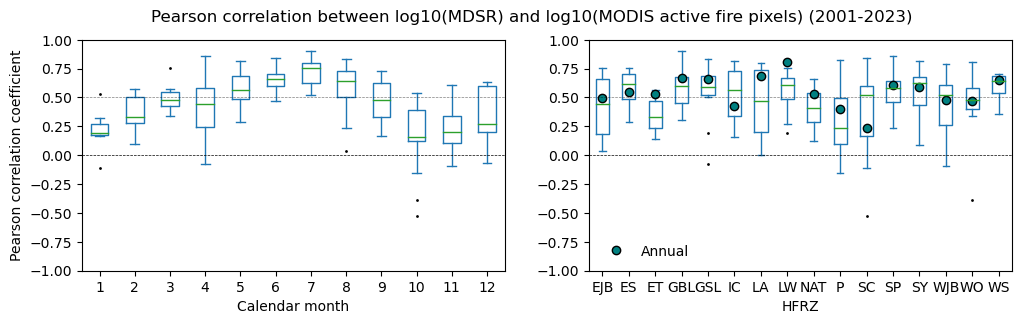

In [446]:
ycorr_log10 = pd.DataFrame.from_dict({"ycorr" : {r : np.corrcoef(np.log10(df.loc[(r), "y"]), np.log10(df.loc[(r), "dsr"]))[0,1] for r in dsr.region_name.values}})

pcorr_log10 = pd.DataFrame({r : {m+1 : np.corrcoef(np.log10(df.loc[(r, m+1), "y"]), np.log10(df.loc[(r, m+1), "dsr"]))[0,1] for m in range(12)} for r in dsr.region_name.values})
boxplot_kwargs = {"flierprops" : {"marker" : "o", "markersize" : 1, "color" : "tab:blue"}}

fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100, facecolor = "w")

ax = axs[0]
pcorr_log10.transpose().plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Calendar month")

ax = axs[1]
pcorr_log10.plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.plot(range(len(ycorr_log10)+1)[1:], ycorr_log10, ls = "", marker = "o", mec = "k", label = "Annual", c = "teal")
ax.set_xlabel("HFRZ")
ax.legend(edgecolor = "w")

for ax in axs:
    ax.axhline(0, color = "k", lw = 0.5, ls = "--")
    ax.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)
    
plt.suptitle("Pearson correlation between log10(MDSR) and log10(MODIS active fire pixels) (2001-2023)")

plt.savefig("fig/expl_mdsr-modis-correlation_log10MDSR.png")

Text(0.5, 0.98, 'Spearman rank correlation between MDSR and MODIS active fire pixels (2001-2023)')

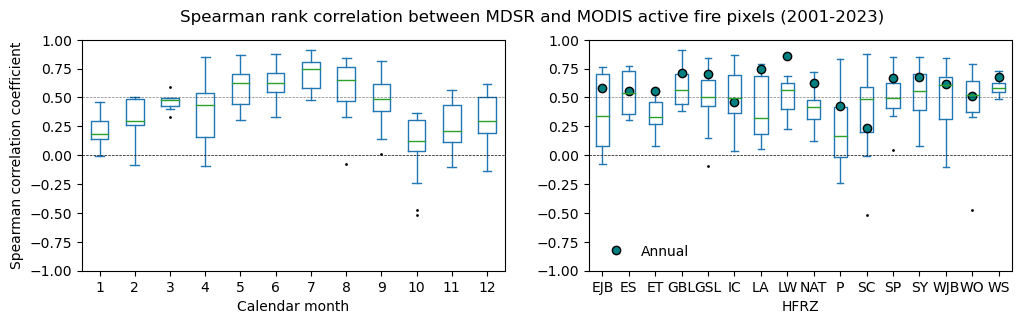

In [459]:
# plot Spearman correlations in each month over all HFRZs
yscorr = pd.DataFrame.from_dict({"ycorr" : {r : spearmanr(df.loc[(r), "y"], df.loc[(r), "dsr"])[0] for r in dsr.region_name.values}})
scorr = pd.DataFrame({r : {m+1 : spearmanr(df.loc[(r, m+1), "y"].values, df.loc[(r, m+1), "dsr"].values)[0] for m in range(12)} for r in dsr.region_name.values})
boxplot_kwargs = {"flierprops" : {"marker" : "o", "markersize" : 1, "color" : "tab:blue"}}

fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100, facecolor = "w")

ax = axs[0]
scorr.transpose().plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.set_ylabel("Spearman correlation coefficient")
ax.set_xlabel("Calendar month")

ax = axs[1]
scorr.plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.plot(range(len(yscorr)+1)[1:], yscorr, ls = "", marker = "o", mec = "k", label = "Annual", c = "teal")
ax.set_xlabel("HFRZ")
ax.legend(edgecolor = "w")

for ax in axs:
    ax.axhline(0, color = "k", lw = 0.5, ls = "--")
    ax.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)
    
plt.suptitle("Spearman rank correlation between MDSR and MODIS active fire pixels (2001-2023)")

# plt.savefig("fig/expl_mdsr-modis-correlation.png")

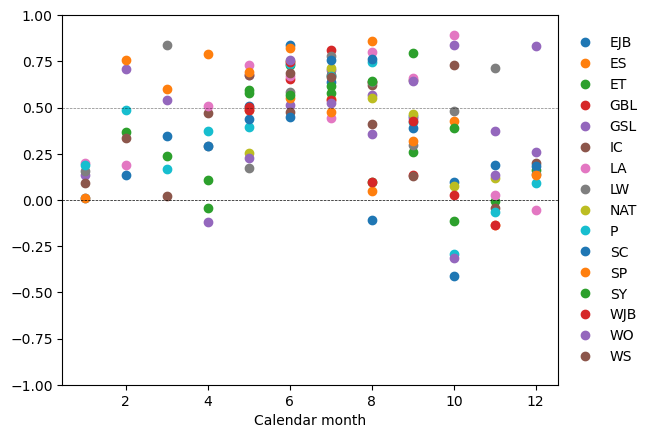

In [277]:
fig = pcorr.plot(ls = "", marker = "o")
fig.legend(loc = "center left", bbox_to_anchor = (1,0.5), edgecolor = "w")
plt.xlabel("Calendar month") 
plt.ylim(-1,1)
plt.axhline(0, color = "k", lw = 0.5, ls = "--")
plt.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)

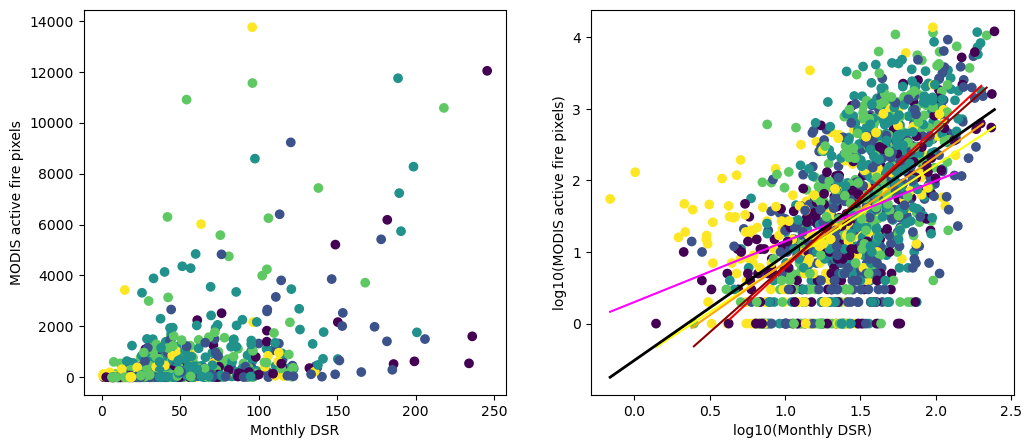

In [355]:
dff = df.reset_index()
dff = dff.loc[dff.y > 0]
dff = dff.loc[[m in [5,6,7,8,9] for m in dff.m]]

fig, axs = plt.subplots(ncols = 2, figsize = (12,5), dpi = 100, facecolor = "w")

plot_kwargs = {"c" : dff.m}

ax = axs[0]
ax.scatter((dff.dsr),(dff.y), **plot_kwargs)
ax.set_xlabel("Monthly DSR")
ax.set_ylabel("MODIS active fire pixels")

ax = axs[1]
ax.scatter(np.log10(dff.dsr), np.log10(dff.y), **plot_kwargs)
ax.set_xlabel("log10(Monthly DSR)")
ax.set_ylabel("log10(MODIS active fire pixels)")

xyline(np.log10(dff.loc[dff.m == 5].dsr), np.log10(dff.loc[dff.m == 5].y), ax = ax, color = "yellow")
xyline(np.log10(dff.loc[dff.m == 6].dsr), np.log10(dff.loc[dff.m == 6].y), ax = ax, color = "orange")
xyline(np.log10(dff.loc[dff.m == 7].dsr), np.log10(dff.loc[dff.m == 7].y), ax = ax, color = "red")
xyline(np.log10(dff.loc[dff.m == 8].dsr), np.log10(dff.loc[dff.m == 8].y), ax = ax, color = "darkred")
xyline(np.log10(dff.loc[dff.m == 9].dsr), np.log10(dff.loc[dff.m == 9].y), ax = ax, color = "magenta")

xyline(np.log10(dff.dsr), np.log10(dff.y), ax = ax, color = "k", lw = 2)


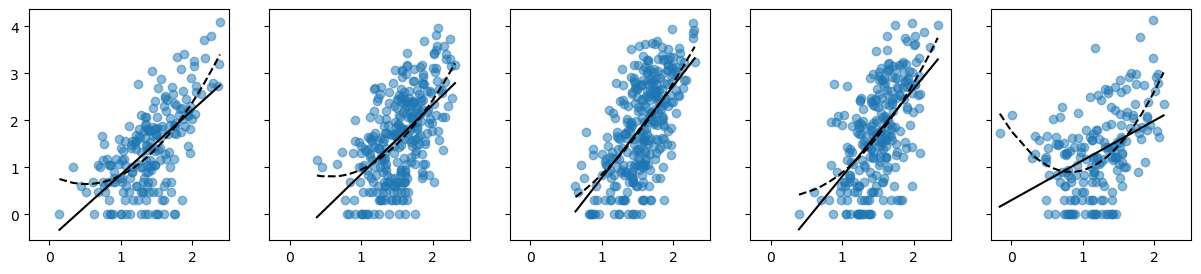

In [374]:
# quick investigation of relationship between monthly DSR and monthly active fire area
fig, axs = plt.subplots(ncols = 5, figsize = (15,3), dpi = 100, facecolor = "w", sharex = True, sharey = True)

for i in range(5):
    ax = axs[i]
    m = range(5,10)[i]
    
    x = np.log10(dff.loc[dff.m == m].dsr)
    y = np.log10(dff.loc[dff.m == m].y)
    
    # ax.set_title(np.corrcoef(x,y)[0,1])
    
    ax.scatter(x,y, alpha = 0.5)
    xyline(x,y,npoly = 1, ax = ax, color = "k")
    xyline(x,y,npoly = 2, ax = ax, ls = "--", color = "k")
